# Colour Calibration

A colour chart (Spyder Checkr® 24 card, Datacolor, NJ, USA) was scanned in a flatbed scanner (HP Scanjet G4010) at a resolution of 1,200 dpi under the same settings as the seeds. The image of the colour chart is used to calculate a colour conversion matrix, which is then applied to all acquired images for optimal colour reproduction.

All required images and files are available on GitHub on the following folders:

files: 
- colour chart scans
- csv file with colour standards
       
test_images: 
- 4 test images with no colour correction

test_results: 
- colour correction image
- difference between original and colour corrected image

results:
- 4 test images after colour correction

## Helper functions and classes

In [93]:
import csv
from dataclasses import dataclass
from itertools import product, chain
from math import ceil
from typing import Tuple, List

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from skimage.exposure import adjust_gamma
from skimage.io import imread
import os

@dataclass
class RegularInterval:
    origin: float
    spacing: float
    n_repeats: int


@dataclass
class Box:
    top_left: Tuple[float, float]
    width: float
    height: float


def plot_colour_image(img, dpi=96, resize_factor=0.25):
    h, w = img.shape[:2]
    fig, ax = plt.subplots()
    fig.set_size_inches(w / dpi * resize_factor, h / dpi * resize_factor)
    fig.set_dpi(dpi)
    ax.imshow(img)
    return fig, ax


def import_standards(filename: str):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        standard_colours_by_col = [tuple(int(f) for f in r) for r in reader]
        standard_colours_by_row = [tuple(rgb / 255) for rgb in flatten(
            np.reshape(standard_colours_by_col, (4, 6, -1)).swapaxes(0, 1))]
    return standard_colours_by_row  # same order as input photo


def make_grid(xi: RegularInterval, yi: RegularInterval) -> List[Tuple[float, float]]:
    return [(yi.origin + row_idx * yi.spacing,
             xi.origin + col_idx * xi.spacing)
            for (col_idx, row_idx)
            in product(range(yi.n_repeats), range(xi.n_repeats))]


def overlay_box(ax, box):
    patch = Rectangle(box.top_left, box.width, box.height, fill=None, ls='--')
    ax.add_patch(patch)


def extract_selection(img, box: Box):
    (x0, y0) = box.top_left
    return img[y0:y0 + box.height, x0:x0 + box.height]


def plot_swatches(swatches: List[Tuple[float, float, float]], n_rows=1):
    n = len(swatches)
    n_cols = ceil(n / n_rows)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=False)
    fig.set_size_inches(5, 5 * n_rows / n_cols)
    for ax in flatten(axes):
        ax.axis('off')
    for colour, ax in zip(swatches, flatten(axes)):
        ax.add_patch(Rectangle((0, 0), 1, 1, color=colour))
    return fig, axes


def plot_swatch_comparison(upper_swatches: List[Tuple[float, float, float]],
                           lower_swatches: List[Tuple[float, float, float]],
                           n_rows: int):
    assert len(upper_swatches) == len(lower_swatches)
    n = len(upper_swatches)
    n_cols = ceil(n / n_rows)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=False)
    swatch_width = 1
    fig.set_size_inches(swatch_width * n_cols, swatch_width * n_rows)
    for c1, c2, ax in zip(upper_swatches, lower_swatches, flatten(axes)):
        # Top-left triangle first
        ax.add_patch(Polygon([(0, 1), (1, 1), (0, 0)], color=c1))  # upper triangle
        ax.add_patch(Polygon([(1, 1), (0, 0), (1, 0)], color=c2))  # lower triangle
        ax.axis('off')
    return fig, axes


def flatten(lst): return chain(*lst)


def colour_average(img): return tuple(np.mean(img, axis=(0, 1)))


def adjust_gamma_rgb(rgb: Tuple[float, float, float], gamma: float):
    return tuple(adjust_gamma(np.array([[rgb]]), gamma)[0][0])

## Extract swatches

### Insert folder containing scanned colour chart

In [104]:
os.chdir('../files') #insert path
os.getcwd()

'/Users/robertadayrell/Library/CloudStorage/OneDrive-Personal/Artigos/2022 Dayrell Image segmentation/scripts/colour_calibration/files'

### Colour chart with reduced size

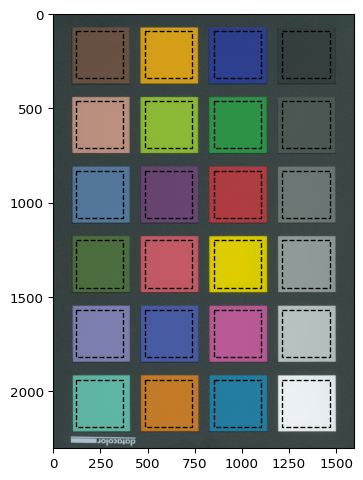

In [105]:
# Import photograph of colour standard
img = imread('colour_chart_small.png') / 255  # want in range [0,1]

# Define spacing of top-left corners of coloured boxes (guess and check)
x_interval = RegularInterval(origin=90, spacing=370, n_repeats=4)
y_interval = RegularInterval(origin=120, spacing=365, n_repeats=6)

# Make outlines and show on original photo
top_left_corners = make_grid(x_interval, y_interval)
selections = [Box(top_left=xy, width=250, height=250) for xy in top_left_corners]
fig, ax = plot_colour_image(img)
for box in selections:
    overlay_box(ax, box)

### Colour chart with original size

This takes longer to process - uncomment code to run.

In [106]:
# # Import photograph of colour standard
# img = imread('colour_chart.png') / 255  # want in range [0,1]

# # Define spacing of top-left corners of coloured boxes (guess and check)
# x_interval = RegularInterval(origin=440, spacing=1485, n_repeats=4)
# y_interval = RegularInterval(origin=300, spacing=1445, n_repeats=6)

# # Make outlines and show on original photo
# top_left_corners = make_grid(x_interval, y_interval)
# selections = [Box(top_left=xy, width=950, height=950) for xy in top_left_corners]
# fig, ax = plot_colour_image(img)
# for box in selections:
#     overlay_box(ax, box)

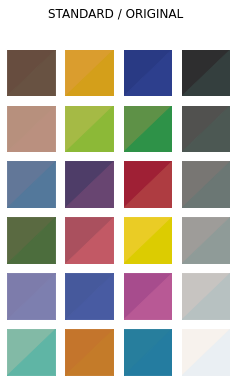

In [107]:
# Create measured and standard swatches
photo_swatches = [colour_average(extract_selection(img, box)) for box in selections]
standard_swatches = import_standards('./spydercheckr24_adobe-rgb.csv')

fig, _ = plot_swatch_comparison(upper_swatches=standard_swatches,
                                lower_swatches=photo_swatches,
                                n_rows=6)
fig.suptitle('STANDARD / ORIGINAL');

## Fit colour correction matrix

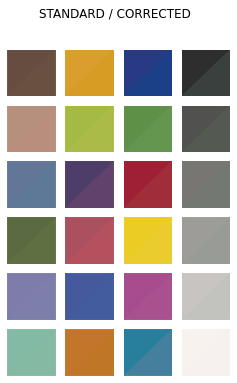

In [108]:
from numpy.linalg import lstsq

# Change to linear RGB space (by removing image's gamma transformation)
linear_standard_swatches = [adjust_gamma_rgb(swatch, 2.2) for swatch in standard_swatches]  # standards are in Adobe RGB, which uses a 2.2 gamma
linear_photo_swatches = [adjust_gamma_rgb(swatch, 2.2) for swatch in photo_swatches]

# least squares correction in RGB space
# Compute colour correction matrix in linear space
# O A = P, where P is the corrected colour, O is the original colour, and A is the correction matrix
# lstsq(O, P) solves O.x = P for x (i.e A for us)
A, *_ = lstsq(np.array(linear_photo_swatches), np.array(linear_standard_swatches), rcond=None)

corrected_linear_photo_swatches = [tuple(rgb) for rgb in np.array(linear_photo_swatches) @ A]
corrected_photo_swatches = [adjust_gamma_rgb(rgb, 1 / 2.2) for rgb in corrected_linear_photo_swatches]
fig, _ = plot_swatch_comparison(standard_swatches, corrected_photo_swatches, n_rows=6)
fig.suptitle('STANDARD / CORRECTED');

## Apply to test image

In [110]:
os.chdir(r'../test_images') #insert path
#os.getcwd()

(<Figure size 1337.75x578 with 1 Axes>, <AxesSubplot: >)

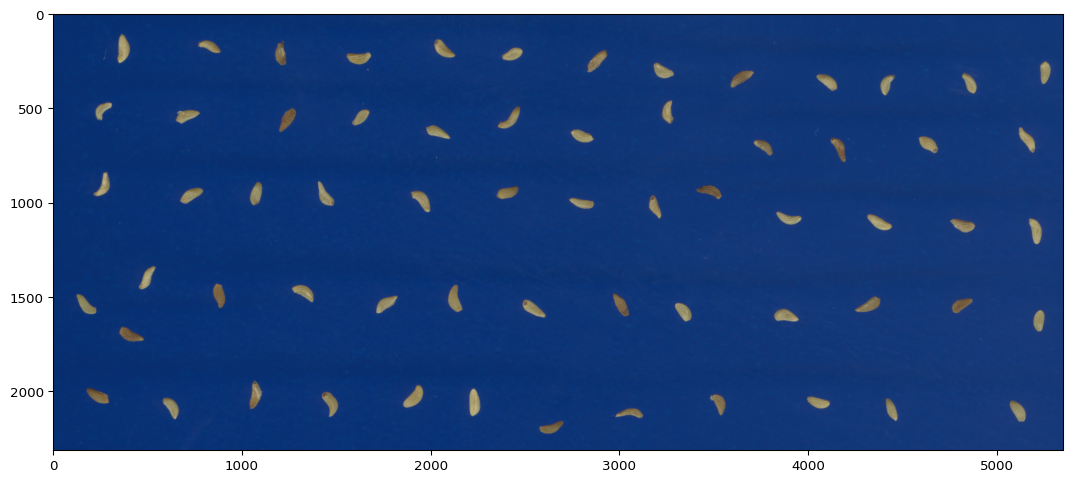

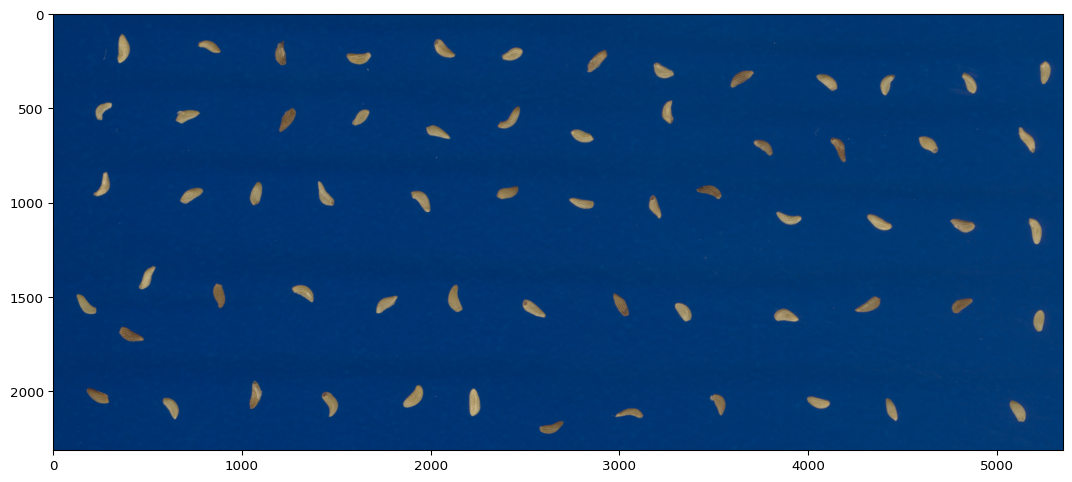

In [111]:
# Original
img = imread('test_img2.png') / 255  # IMPORTANT: Need in 0-1 format
plot_colour_image(img)

# Apply correction
linear_img = adjust_gamma(img, 2.2)
corrected_linear_img = linear_img @ A
corrected_linear_img[corrected_linear_img < 0] = 0  # clip at 0
corrected_linear_img[corrected_linear_img > 1] = 1  # clip at 1
corrected_img = adjust_gamma(corrected_linear_img, 1/2.2) #Adobe RGB
plot_colour_image(corrected_img)

## print files to seed differences
# diff_img = img_as_ubyte(img - corrected_img)
# corrected_img = img_as_ubyte(corrected_img)
## colour corrected image
# imsave(r'/Users/robertadayrell/OneDrive/Artigos/2022 Dayrell Image segmentation/scripts/colour_calibration/test_results/test_img2_cal.png', corrected_img, check_contrast=False)
## difference between the two images
# imsave(r'/Users/robertadayrell/OneDrive/Artigos/2022 Dayrell Image segmentation/scripts/colour_calibration/test_results/test_img2_diff.png', diff_img, check_contrast=False)

## Apply to folder with all scanned images

In [112]:
from skimage.io import imsave
from skimage import io
from skimage import img_as_ubyte
import sys
from PIL import Image
io.use_plugin('pil')

In [113]:
# Insert path with scanned images
#os.chdir(r'../test_images')
#os.getcwd()

### Export with gamma 2.2 (Adobe RGB)
Insert path to save results

In [114]:
for f in os.listdir("."):
    if f.endswith(".png"): # Change format accordingly
        i = imread(f) / 255
        #i = imread(f, plugin='pil') / 255 # Use this for images in TIFF format
        fn, fext = os.path.splitext(f)
        linear_img = adjust_gamma(i, 2.2)
        corrected_linear_img = linear_img @ A
        corrected_linear_img[corrected_linear_img < 0] = 0  # clip at 0
        corrected_linear_img[corrected_linear_img > 1] = 1  # clip at 1
        corrected_img = adjust_gamma(corrected_linear_img, 1/2.2)
        corrected_img = img_as_ubyte(corrected_img)
        # Edit path
        imsave(r'../results/{}_cal.png'.format(fn), corrected_img, check_contrast=False)